In [6]:
import os
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from process import compress_video

import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense

%matplotlib inline

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and configured")
    except RuntimeError as e:
        print(e)

GPU is available and configured


## Label Load 및 추출 함수

In [8]:
import numpy as np

def quadrant_diff(arr, highlight_map):
    """
    Calculate differences within each quadrant of the frame and update highlight_map based on these differences, 
    using the standard deviation of all differences as the threshold.

    Args:
    arr (List of np.array): Each element is a 9x256x256x1 numpy array representing a frame.

    Returns:
    List: Updated highlight_map indicating highlights based on quadrant differences.
    """
    all_diffs = []
    
    for i in range(len(arr) - 1):
        for quadrant in range(4):
            # 4개로 분리된 frame의 차이를 계산하는 부분
            quarter_shape = (arr[i].shape[1] // 2, arr[i].shape[2] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = arr[i][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = arr[i + 1][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]

            # 각 frame의 차이를 계산
            diff = np.abs(current_quarter - next_quarter).sum()
            all_diffs.append(diff)
    
    # 계산된 frame 차이의 표준편차를 임계값으로 설정
    threshold = np.std(all_diffs)
    
    # 해당 임계값을 바탕으로 frame 라벨 update
    for i in range(len(arr) - 1):
        count_above_threshold = 0
        for quadrant in range(4):
            quarter_shape = (arr[i].shape[1] // 2, arr[i].shape[2] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = arr[i][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = arr[i + 1][:, x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            
            diff = np.abs(current_quarter - next_quarter).sum()

            if diff > threshold:
                count_above_threshold += 1
        
        if (count_above_threshold >= 1) and (count_above_threshold < 4) and (highlight_map[i] == 1):
            highlight_map[i] = 2

    return highlight_map


In [9]:
# Load JSON data
with open('test.json', 'r') as file:
    json_data = json.load(file)

def parse_annotations(annotation:list, block_num:int):
    """
    Extracts Every Annotation from json label file
    
    Args:
    annotations(List): List of Dictionary for annotations label with highlight and represent

    Returns:
    List: Whether each block is Highlight or not
    """
    global video_path
    highlight_map = {}

    video_path = annotation["video_path"]
    annotations = annotation["annots"]
    
    for annot in annotations:
        highlights = annot['highlight']

        for num in highlights:
            highlight_map[num] = 1
            
    ret = [0 for _ in range(block_num)]
    
    for key in highlight_map.keys():
        try:
            ret[key] = 1
        except:
            ret.append(1)

    video_frames = np.load(video_path)
    ret = quadrant_diff(video_frames, ret)

    count_0 = ret.count(0)
    count_1 = ret.count(1)
    count_2 = ret.count(2)
    print(f"Count of 0: {count_0}")
    print(f"Count of 1: {count_1}")
    print(f"Count of 2: {count_2}")

    return video_frames, ret

## Model - Video

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, Conv3D, LayerNormalization, Activation, GlobalAveragePooling2D, Dense, TimeDistributed, Flatten
from tensorflow.keras.models import Model

def build_resnet_based_cnn(input_shape=(9, 256, 256, 1)):
    # Define ResNet base model
    base_model = ResNet50(include_top=False, weights=None, input_shape=(256, 256, 3))
    base_model.trainable = True

    inputs = Input(shape=input_shape)

    # Adjust input to have 3 channels
    x = TimeDistributed(Conv2D(3, (1, 1), padding='same'))(inputs)
    x = TimeDistributed(LayerNormalization())(x)
    x = TimeDistributed(Activation('relu'))(x)

    # Apply the base ResNet model
    x = TimeDistributed(base_model)(x)

    # Additional Conv2D and LayerNormalization layers
    x = Conv3D(64, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv3D(128, (3, 3, 3), padding='same')(x)
    x = LayerNormalization()(x)
    x = Activation('relu')(x)

    # Flatten the output
    x = TimeDistributed(GlobalAveragePooling2D())(x)
    x = TimeDistributed(Flatten())(x)

    # Fully connected layers
    x = TimeDistributed(Dense(256, activation='relu'))(x)
    x = TimeDistributed(LayerNormalization())(x)
    x = TimeDistributed(Dense(128, activation='relu'))(x)
    x = TimeDistributed(LayerNormalization())(x)
    
    # Output layer
    outputs = TimeDistributed(Dense(3, activation='softmax'))(x)

    model = Model(inputs, outputs)
    return model

with tf.device('/GPU:0'):
    resnet_cnn_model = build_resnet_based_cnn()
    resnet_cnn_model.compile(optimizer='adam', 
                             loss='categorical_crossentropy', 
                             metrics=['accuracy'])

    resnet_cnn_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9, 256, 256, 1)]  0         
                                                                 
 time_distributed_1 (TimeDis  (None, 9, 256, 256, 3)   6         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 9, 256, 256, 3)   6         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 9, 256, 256, 3)   0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 9, 8, 8, 2048)    23587712  
 tributed)                                                   

## Model Trainer 함수

In [13]:
def trainer(model):
    # data_list = os.listdir("processed/video") # 동영상 데이터 
    json_path = 'processed\label\processed_video_data.json'
    model_path = './video_3D_model.h5'

    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Loaded existing model.")
    else:
        print("No existing model found, starting training new model.")

    with open(json_path, 'r') as file:
        json_data = json.load(file)

    train_length = int(len(json_data) * 0.7)
    
    train_data = json_data[:train_length]
    test_data = json_data[train_length:]
    all_histories = []

    ## Training phase
    for json_dict in tqdm(train_data):
        video, label = parse_annotations(json_dict, json_dict['three_secs'][-1])
        
        X = video
        y = np.array(label) 

        min_length = min(len(X), len(y))
        X, y = X[:min_length], y[:min_length]

        y = to_categorical(y, num_classes=3)
        with tf.device('/GPU:0'):
            history = model.fit(X, y, 
                                epochs=10, 
                                verbose=0, 
                                batch_size=4)
        
        all_histories.append(history.history)
    
    model.save(model_path) 

    ## Test phase
    for i, json_dict in enumerate(test_data):
        video, label = parse_annotations(json_dict, json_dict['three_secs'][-1] + 1)
        
        X = video
        y = np.array(label) 
        
        min_length = min(len(X), len(y))
        X, y = X[:min_length], y[:min_length]

        y = to_categorical(y, num_classes=3)
        
        print(f"Test {i} :: {model.evaluate(X, y)}")

    return model, all_histories

In [14]:
def plot_training_history(histories):
    epochs = range(1, len(histories[0]['loss']) + 1)
    all_loss = [h['loss'] for h in histories]
    all_acc = [h['accuracy'] for h in histories]

    plt.figure(figsize=(20, 15))
    plt.subplot(1, 2, 1)
    for i, loss in enumerate(all_loss):
        plt.plot(epochs, loss, label=f'Training {i+1}')
    plt.title('Loss over training videos')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.subplot(1, 2, 2)
    for i, acc in enumerate(all_acc):
        plt.plot(epochs, acc, label=f'Training {i+1}')
    plt.title('Accuracy over training videos')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [15]:
model_traied, history = trainer(resnet_cnn_model)

Loaded existing model.


  0%|          | 0/69 [00:00<?, ?it/s]

Count of 0: 38
Count of 1: 8
Count of 2: 7


  1%|▏         | 1/69 [00:45<51:38, 45.57s/it]

Count of 0: 35
Count of 1: 10
Count of 2: 7


  3%|▎         | 2/69 [01:22<45:23, 40.65s/it]

Count of 0: 58
Count of 1: 5
Count of 2: 12


  4%|▍         | 3/69 [02:17<51:38, 46.95s/it]

Count of 0: 72
Count of 1: 20
Count of 2: 7


  6%|▌         | 4/69 [03:28<1:01:07, 56.42s/it]

Count of 0: 52
Count of 1: 23
Count of 2: 3


  7%|▋         | 5/69 [04:25<1:00:21, 56.58s/it]

Count of 0: 26
Count of 1: 12
Count of 2: 4


  9%|▊         | 6/69 [04:55<49:57, 47.58s/it]  

Count of 0: 32
Count of 1: 11
Count of 2: 0


 10%|█         | 7/69 [05:25<43:28, 42.07s/it]

Count of 0: 52
Count of 1: 6
Count of 2: 13


 12%|█▏        | 8/69 [06:16<45:34, 44.83s/it]

Count of 0: 58
Count of 1: 24
Count of 2: 9


 13%|█▎        | 9/69 [07:21<51:08, 51.15s/it]

Count of 0: 31
Count of 1: 10
Count of 2: 3


 14%|█▍        | 10/69 [07:53<44:18, 45.06s/it]

Count of 0: 65
Count of 1: 31
Count of 2: 0


 16%|█▌        | 11/69 [09:00<50:15, 51.99s/it]

Count of 0: 67
Count of 1: 23
Count of 2: 7


 17%|█▋        | 12/69 [10:10<54:30, 57.38s/it]

Count of 0: 54
Count of 1: 17
Count of 2: 3


 19%|█▉        | 13/69 [11:03<52:16, 56.01s/it]

Count of 0: 54
Count of 1: 14
Count of 2: 7


 20%|██        | 14/69 [11:56<50:39, 55.27s/it]

Count of 0: 54
Count of 1: 19
Count of 2: 4


 22%|██▏       | 15/69 [12:52<49:44, 55.26s/it]

Count of 0: 37
Count of 1: 12
Count of 2: 0


 23%|██▎       | 16/69 [13:27<43:32, 49.29s/it]

Count of 0: 57
Count of 1: 20
Count of 2: 9


 25%|██▍       | 17/69 [14:29<46:03, 53.14s/it]

Count of 0: 43
Count of 1: 14
Count of 2: 9


 26%|██▌       | 18/69 [15:17<43:43, 51.44s/it]

Count of 0: 41
Count of 1: 16
Count of 2: 5


 28%|██▊       | 19/69 [16:01<41:10, 49.42s/it]

Count of 0: 64
Count of 1: 16
Count of 2: 11


 29%|██▉       | 20/69 [17:07<44:16, 54.22s/it]

Count of 0: 53
Count of 1: 21
Count of 2: 3


 30%|███       | 21/69 [18:02<43:37, 54.54s/it]

Count of 0: 52
Count of 1: 7
Count of 2: 13


 32%|███▏      | 22/69 [18:54<42:03, 53.69s/it]

Count of 0: 47
Count of 1: 13
Count of 2: 5


 33%|███▎      | 23/69 [19:40<39:32, 51.58s/it]

Count of 0: 59
Count of 1: 20
Count of 2: 5


 35%|███▍      | 24/69 [20:40<40:33, 54.08s/it]

Count of 0: 58
Count of 1: 18
Count of 2: 2


 36%|███▌      | 25/69 [21:35<39:52, 54.37s/it]

Count of 0: 45
Count of 1: 11
Count of 2: 2


 38%|███▊      | 26/69 [22:17<36:14, 50.58s/it]

Count of 0: 55
Count of 1: 22
Count of 2: 8


 39%|███▉      | 27/69 [23:18<37:35, 53.70s/it]

Count of 0: 60
Count of 1: 16
Count of 2: 3


 41%|████      | 28/69 [24:14<37:14, 54.50s/it]

Count of 0: 50
Count of 1: 18
Count of 2: 5


 42%|████▏     | 29/69 [25:07<35:52, 53.81s/it]

Count of 0: 51
Count of 1: 6
Count of 2: 2


 43%|████▎     | 30/69 [25:49<32:41, 50.30s/it]

Count of 0: 72
Count of 1: 11
Count of 2: 11


 45%|████▍     | 31/69 [26:56<35:02, 55.32s/it]

Count of 0: 68
Count of 1: 23
Count of 2: 7


 46%|████▋     | 32/69 [28:06<36:48, 59.69s/it]

Count of 0: 63
Count of 1: 20
Count of 2: 6


 48%|████▊     | 33/69 [29:09<36:30, 60.85s/it]

Count of 0: 54
Count of 1: 12
Count of 2: 9


 49%|████▉     | 34/69 [30:03<34:13, 58.67s/it]

Count of 0: 72
Count of 1: 2
Count of 2: 25


 51%|█████     | 35/69 [31:13<35:16, 62.24s/it]

Count of 0: 56
Count of 1: 19
Count of 2: 2


 52%|█████▏    | 36/69 [32:08<33:02, 60.09s/it]

Count of 0: 41
Count of 1: 15
Count of 2: 4


 54%|█████▎    | 37/69 [32:51<29:16, 54.89s/it]

Count of 0: 50
Count of 1: 20
Count of 2: 3


 55%|█████▌    | 38/69 [33:43<27:56, 54.09s/it]

Count of 0: 43
Count of 1: 17
Count of 2: 5


 57%|█████▋    | 39/69 [34:30<25:53, 51.80s/it]

Count of 0: 43
Count of 1: 15
Count of 2: 9


 58%|█████▊    | 40/69 [35:18<24:27, 50.60s/it]

Count of 0: 60
Count of 1: 26
Count of 2: 7


 59%|█████▉    | 41/69 [36:24<25:49, 55.34s/it]

Count of 0: 34
Count of 1: 10
Count of 2: 4


 61%|██████    | 42/69 [36:58<22:03, 49.03s/it]

Count of 0: 50
Count of 1: 20
Count of 2: 0


 62%|██████▏   | 43/69 [37:49<21:25, 49.42s/it]

Count of 0: 51
Count of 1: 20
Count of 2: 7


 64%|██████▍   | 44/69 [38:45<21:28, 51.56s/it]

Count of 0: 54
Count of 1: 17
Count of 2: 18


 65%|██████▌   | 45/69 [39:50<22:11, 55.47s/it]

Count of 0: 47
Count of 1: 21
Count of 2: 2


 67%|██████▋   | 46/69 [40:41<20:45, 54.16s/it]

Count of 0: 41
Count of 1: 14
Count of 2: 0


 68%|██████▊   | 47/69 [41:21<18:18, 49.93s/it]

Count of 0: 71
Count of 1: 25
Count of 2: 2


 70%|██████▉   | 48/69 [42:33<19:44, 56.40s/it]

Count of 0: 35
Count of 1: 10
Count of 2: 1


 71%|███████   | 49/69 [43:06<16:31, 49.58s/it]

Count of 0: 51
Count of 1: 33
Count of 2: 0


 72%|███████▏  | 50/69 [44:08<16:49, 53.15s/it]

Count of 0: 53
Count of 1: 27
Count of 2: 1


 74%|███████▍  | 51/69 [45:08<16:35, 55.31s/it]

Count of 0: 70
Count of 1: 20
Count of 2: 5


 75%|███████▌  | 52/69 [46:17<16:50, 59.46s/it]

Count of 0: 57
Count of 1: 12
Count of 2: 8


 77%|███████▋  | 53/69 [47:14<15:39, 58.74s/it]

Count of 0: 59
Count of 1: 24
Count of 2: 5


 78%|███████▊  | 54/69 [48:17<14:59, 59.96s/it]

Count of 0: 55
Count of 1: 12
Count of 2: 11


 80%|███████▉  | 55/69 [49:12<13:40, 58.57s/it]

Count of 0: 50
Count of 1: 27
Count of 2: 3


 81%|████████  | 56/69 [50:09<12:34, 58.07s/it]

Count of 0: 49
Count of 1: 19
Count of 2: 0


 83%|████████▎ | 57/69 [50:58<11:02, 55.20s/it]

Count of 0: 62
Count of 1: 26
Count of 2: 5


 84%|████████▍ | 58/69 [52:04<10:43, 58.52s/it]

Count of 0: 56
Count of 1: 10
Count of 2: 14


 86%|████████▌ | 59/69 [53:01<09:40, 58.05s/it]

Count of 0: 50
Count of 1: 24
Count of 2: 6


 87%|████████▋ | 60/69 [53:57<08:37, 57.53s/it]

Count of 0: 54
Count of 1: 14
Count of 2: 4


 88%|████████▊ | 61/69 [54:48<07:24, 55.62s/it]

Count of 0: 35
Count of 1: 10
Count of 2: 3


 90%|████████▉ | 62/69 [55:23<05:44, 49.20s/it]

Count of 0: 55
Count of 1: 25
Count of 2: 7


 91%|█████████▏| 63/69 [56:25<05:18, 53.06s/it]

Count of 0: 35
Count of 1: 15
Count of 2: 2


 93%|█████████▎| 64/69 [57:02<04:01, 48.24s/it]

Count of 0: 27
Count of 1: 15
Count of 2: 3


 94%|█████████▍| 65/69 [57:34<02:53, 43.42s/it]

Count of 0: 43
Count of 1: 19
Count of 2: 5


 96%|█████████▌| 66/69 [58:22<02:14, 44.76s/it]

Count of 0: 70
Count of 1: 26
Count of 2: 2


 97%|█████████▋| 67/69 [59:32<01:44, 52.31s/it]

Count of 0: 44
Count of 1: 11
Count of 2: 3


 99%|█████████▊| 68/69 [1:00:13<00:49, 49.05s/it]

Count of 0: 49
Count of 1: 7
Count of 2: 14


100%|██████████| 69/69 [1:01:03<00:00, 53.09s/it]


Count of 0: 58
Count of 1: 18
Count of 2: 7
3/3 [==============================] - 3s 474ms/step - loss: 0.9210 - accuracy: 0.6024
Test 0 :: [0.9209601879119873, 0.6024096608161926]
Count of 0: 64
Count of 1: 15
Count of 2: 1
3/3 [==============================] - 1s 440ms/step - loss: 0.7574 - accuracy: 0.7000
Test 1 :: [0.7574036121368408, 0.699999988079071]
Count of 0: 65
Count of 1: 27
Count of 2: 3
3/3 [==============================] - 2s 601ms/step - loss: 1.0369 - accuracy: 0.7021
Test 2 :: [1.0369017124176025, 0.7021276354789734]
Count of 0: 50
Count of 1: 16
Count of 2: 7
3/3 [==============================] - 1s 347ms/step - loss: 0.9967 - accuracy: 0.5972
Test 3 :: [0.9967398047447205, 0.5972222089767456]
Count of 0: 60
Count of 1: 19
Count of 2: 7
3/3 [==============================] - 2s 493ms/step - loss: 0.9470 - accuracy: 0.6118
Test 4 :: [0.9470076560974121, 0.6117647290229797]
Count of 0: 41
Count of 1: 13
Count of 2: 0
2/2 [==============================] - 1s 321ms

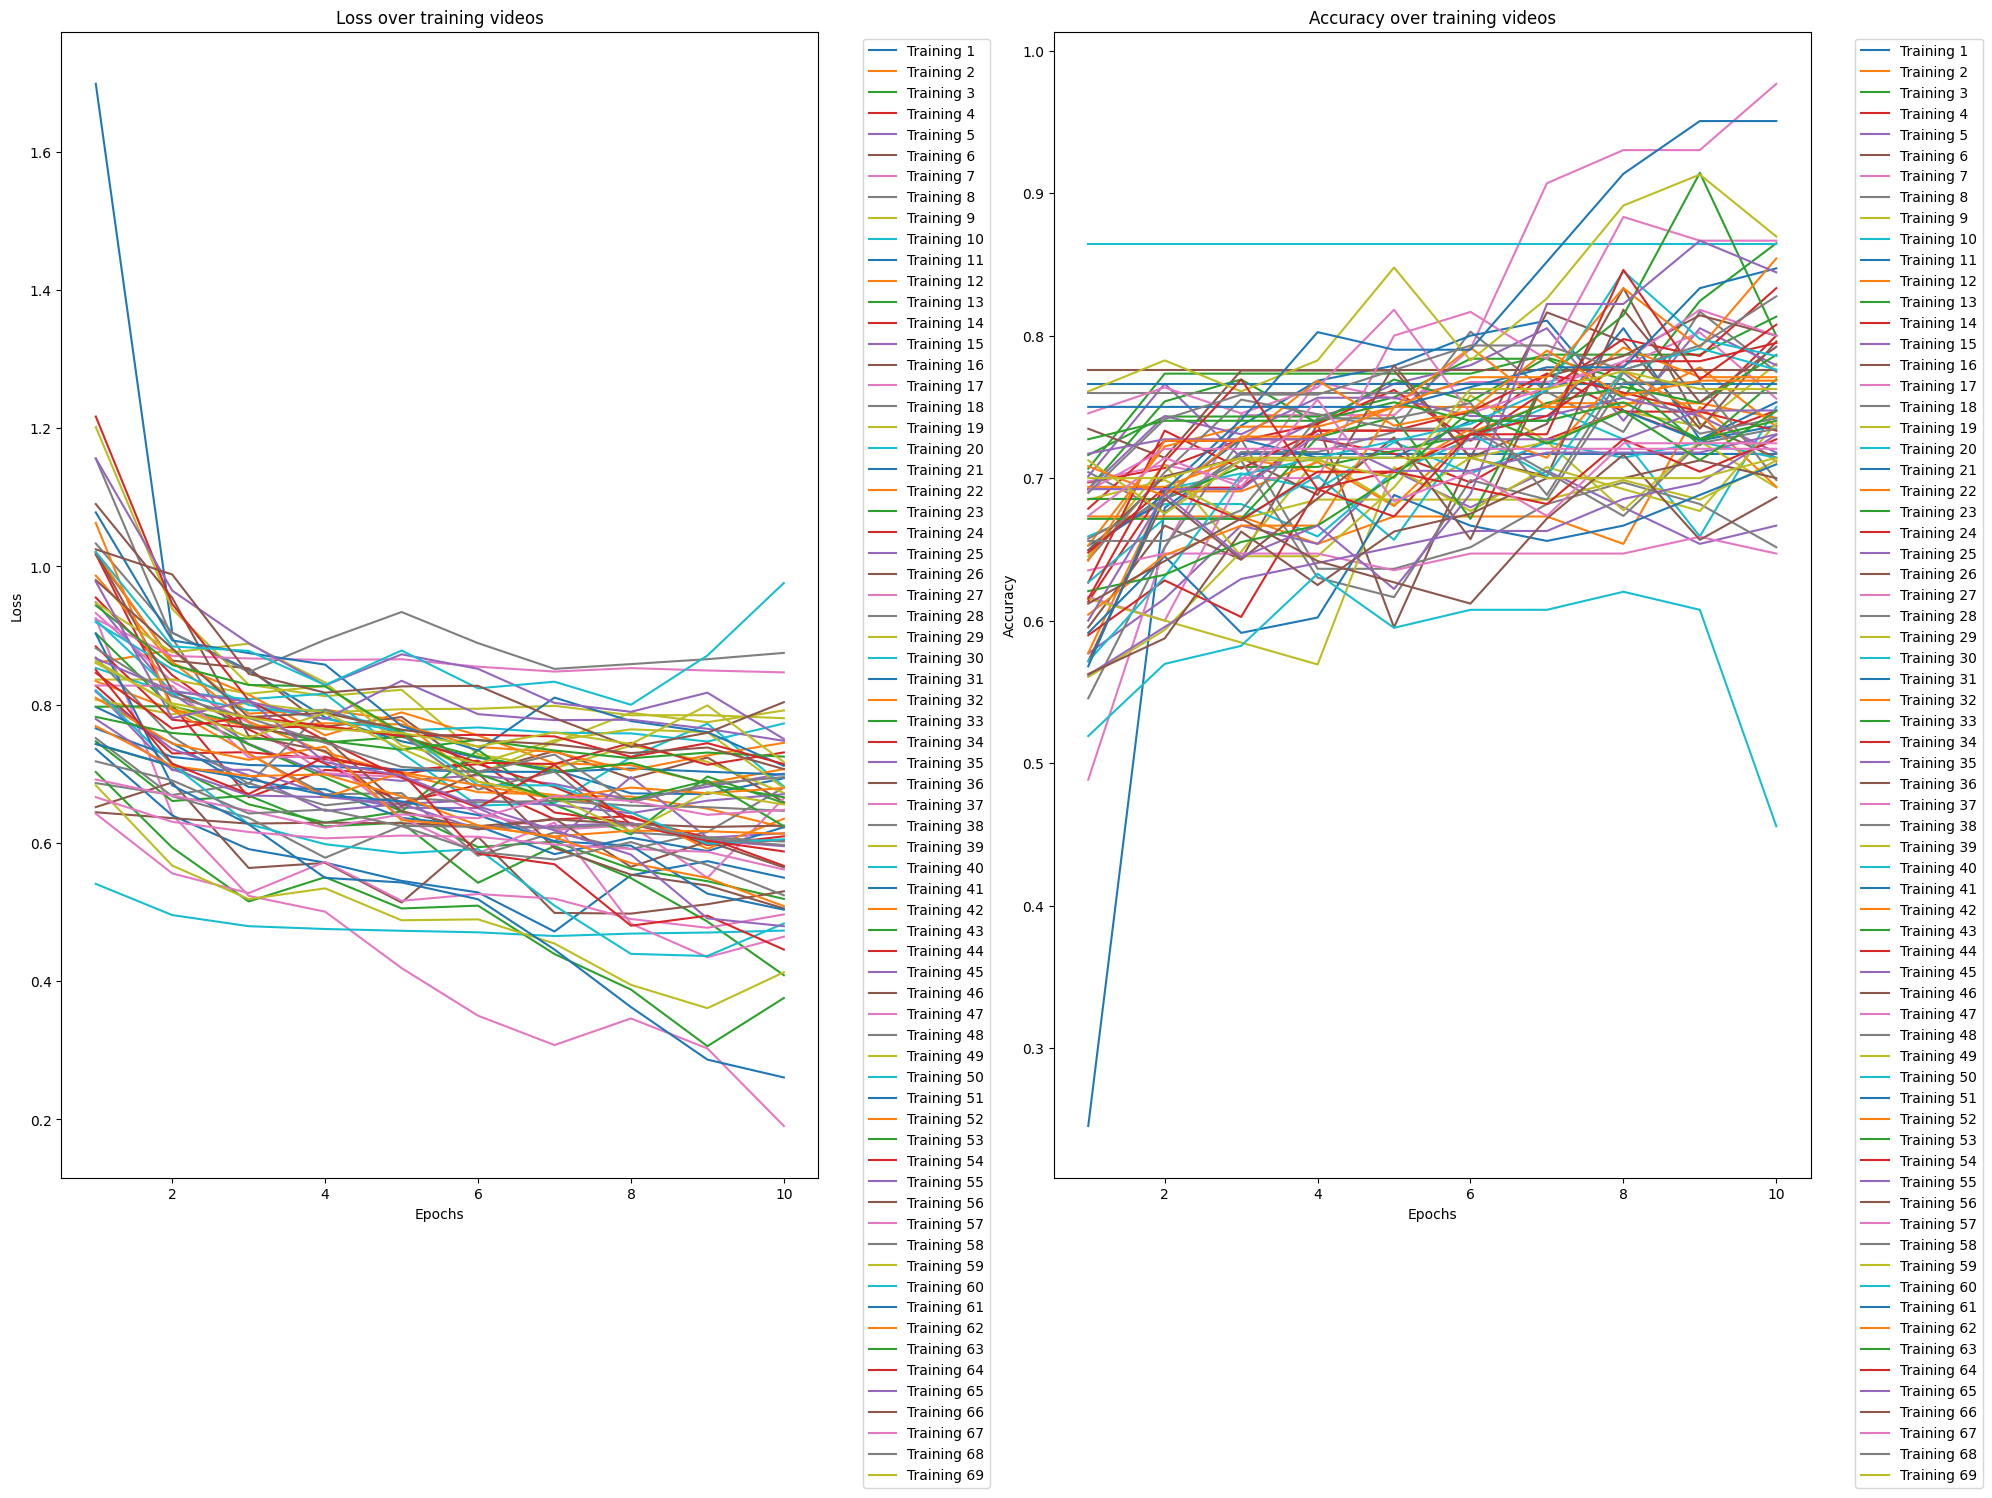

In [16]:
plot_training_history(history) ## 3D모델

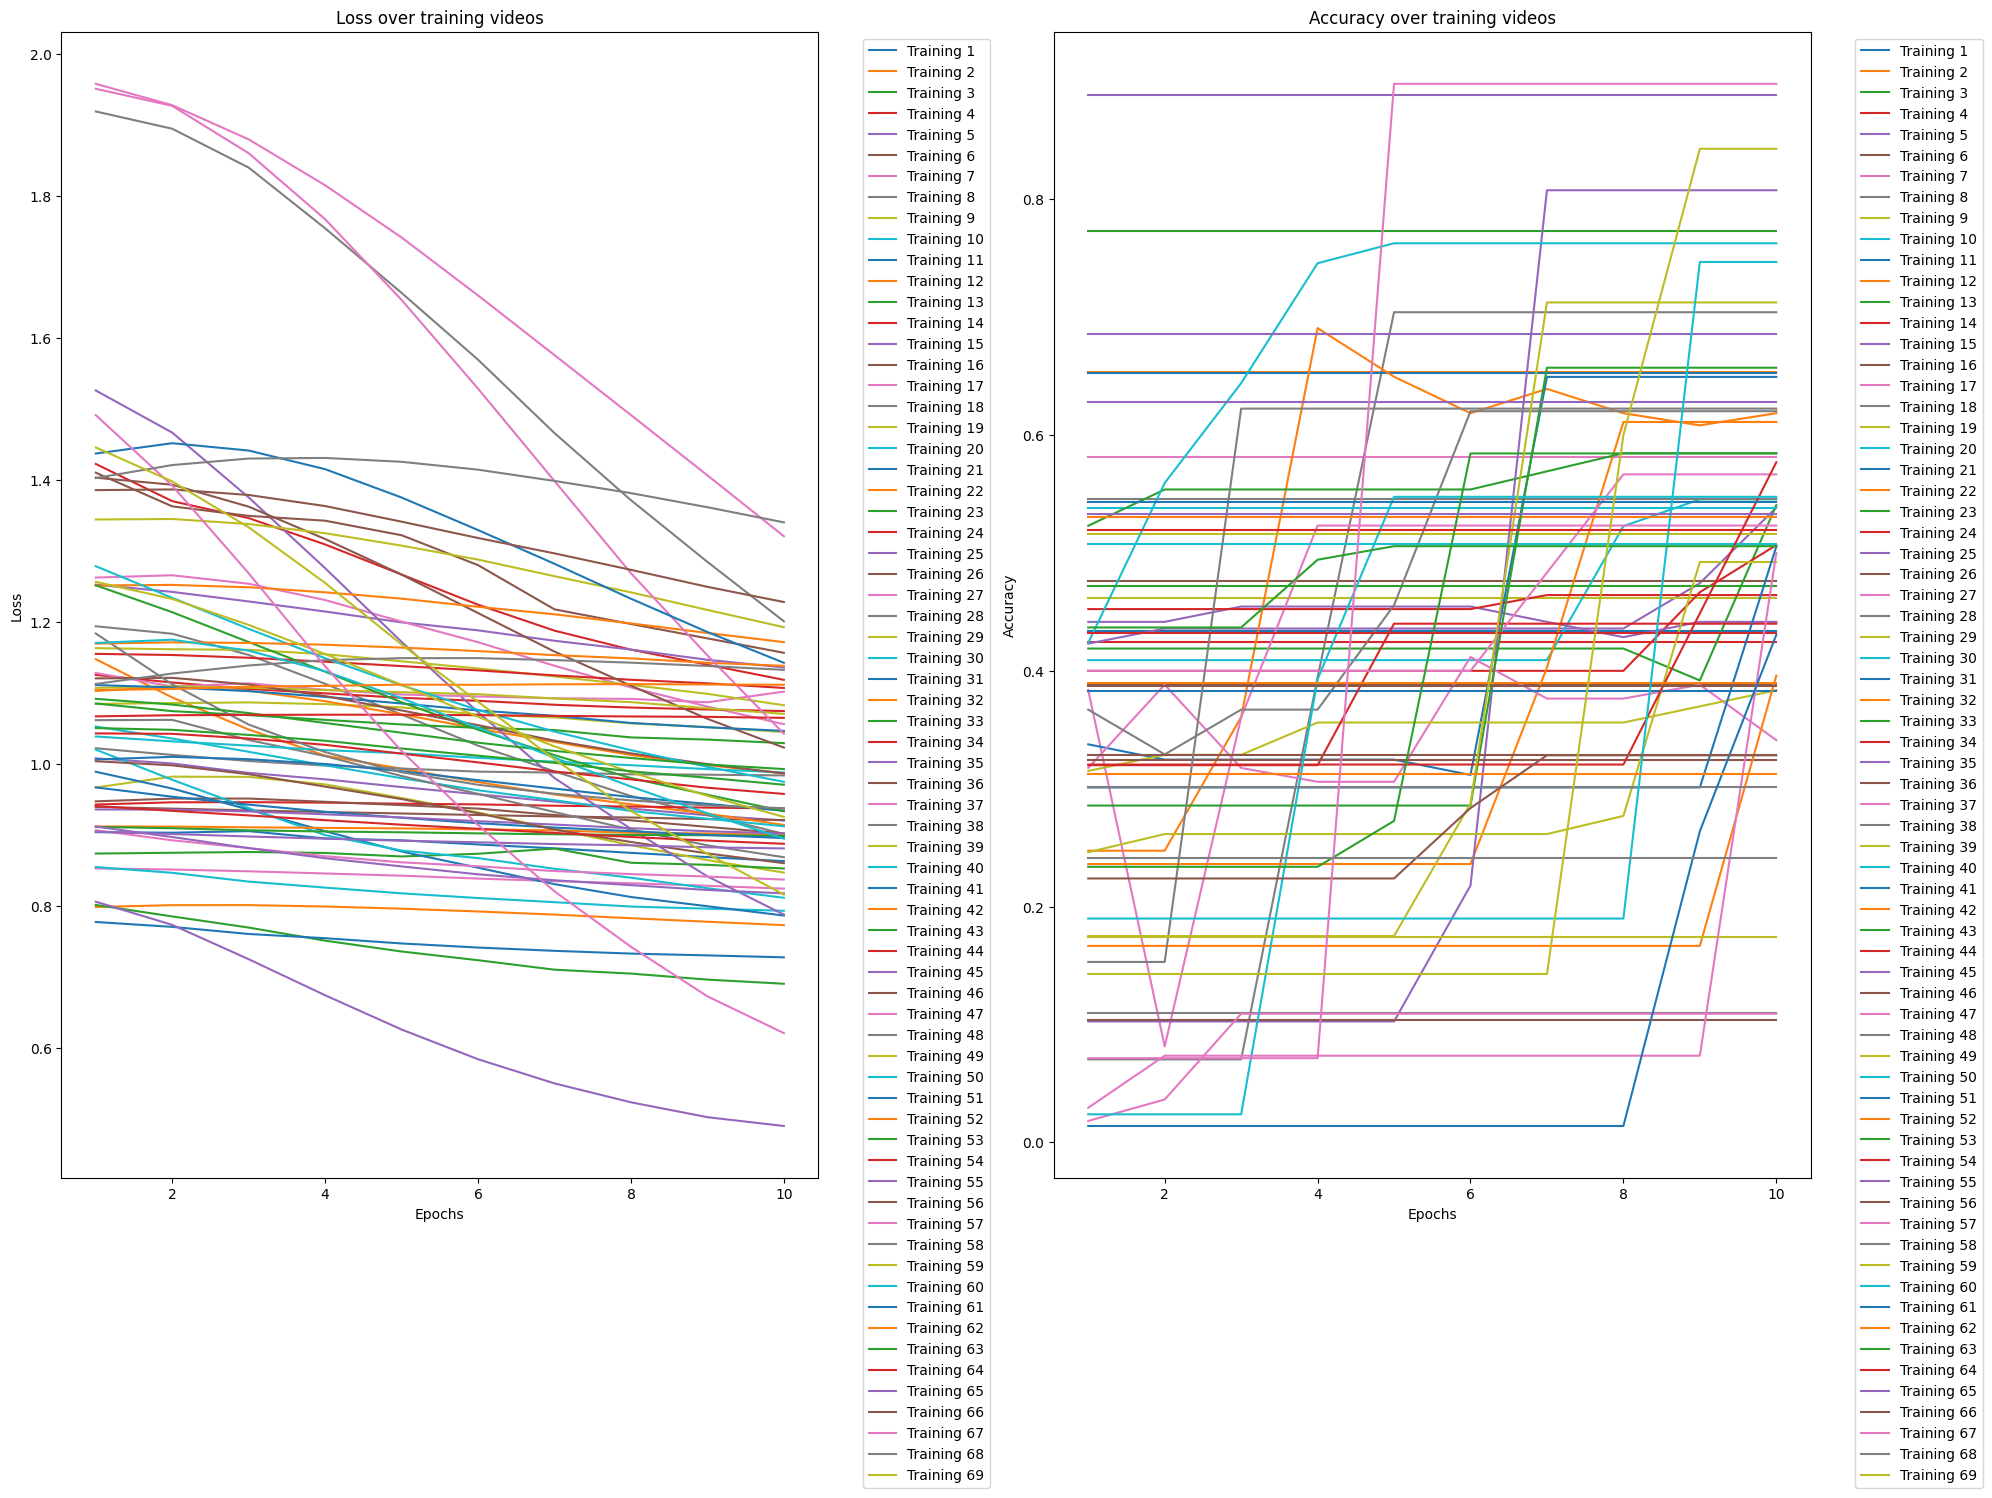

In [ ]:
plot_training_history(history) ## BASELINE

## Train Audio model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_simple_cnn():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(130, 130, 1)),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
 
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50

def create_resnet50_model():
    input_layer = tf.keras.Input(shape=(130, 130, 1))
    
    x = tf.tile(input_layer, [1, 1, 1, 3])

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=x)
    base_model.trainable = False 

    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax') 
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
model_audio_resnet = create_resnet50_model()
model_audio_resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 51200)             0         
                                                                 
 dense_5 (Dense)             (None, 128)               6553728   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 3)                 387       
                                                                 
Total params: 30,141,827
Trainable params: 6,554,115
Non-trainable params: 23,587,712
___________________________________

In [ ]:
model_audio = create_simple_cnn()
model_audio.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 128)     

In [ ]:
import numpy as np

def quadrant_diff(arr, highlight_map):
    all_diffs = []
    
    for i in range(len(arr) - 1):
        current_frame = arr[i]
        next_frame = arr[i + 1]
        if current_frame.ndim == 2: 
            current_frame = current_frame[..., np.newaxis]
            next_frame = next_frame[..., np.newaxis]

        for quadrant in range(4):
            quarter_shape = (current_frame.shape[0] // 2, current_frame.shape[1] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = current_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = next_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            
            diff = np.abs(current_quarter - next_quarter).sum()
            all_diffs.append(diff)
    
    threshold = np.std(all_diffs)
    
    for i in range(len(arr) - 1):
        count_above_threshold = 0
        current_frame = arr[i]
        next_frame = arr[i + 1]
        if current_frame.ndim == 2:
            current_frame = current_frame[..., np.newaxis]
            next_frame = next_frame[..., np.newaxis]

        for quadrant in range(4):
            quarter_shape = (current_frame.shape[0] // 2, current_frame.shape[1] // 2)
            x_start = (quadrant % 2) * quarter_shape[0]
            y_start = (quadrant // 2) * quarter_shape[1]
            current_quarter = current_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            next_quarter = next_frame[x_start:x_start + quarter_shape[0], y_start:y_start + quarter_shape[1], :]
            
            diff = np.abs(current_quarter - next_quarter).sum()
            if diff > threshold:
                count_above_threshold += 1
        
        if (count_above_threshold >= 1) and (count_above_threshold < 4) and (highlight_map[i] == 1):
            highlight_map[i] = 2

    return highlight_map


In [ ]:
# Load JSON data
with open('test.json', 'r') as file:
    json_data = json.load(file)

def parse_annotations(annotation:list, block_num:int):
    """
    Extracts Every Annotation from json label file
    
    Args:
    annotations(List): List of Dictionary for annotations label with highlight and represent

    Returns:
    List: Whether each block is Highlight or not
    """
    global video_path
    highlight_map = {}

    video_path = annotation["audio_path"]
    annotations = annotation["annots"]
    
    for annot in annotations:
        highlights = annot['highlight']

        for num in highlights:
            highlight_map[num] = 1
            
    ret = [0 for _ in range(block_num)]
    
    for key in highlight_map.keys():
        try:
            ret[key] = 1
        except:
            ret.append(1)

    video_frames = np.load(video_path)
    ret = quadrant_diff(video_frames, ret)
                
    return video_frames, ret

In [ ]:
def trainer(model):
    # data_list = os.listdir("processed/video") # 동영상 데이터 
    json_path = 'processed\label\processed_video_data.json'
    model_path = './audio_model.h5'

    if os.path.exists(model_path):
        model = load_model(model_path)
        print("Loaded existing model.")
    else:
        print("No existing model found, starting training new model.")

    with open(json_path, 'r') as file:
        json_data = json.load(file)

    train_length = int(len(json_data) * 0.7)
    
    train_data = json_data[:train_length]
    test_data = json_data[train_length:]
    all_histories = []

    ## 학습 부분
    for json_dict in tqdm(train_data):
        video, label = parse_annotations(json_dict, json_dict['three_secs'][-1])
        
        X = video # i번 영상의 npy 파일
        y = np.array(label) # 1번 영상에 대한 각 블럭의 하이라이트 여부

        min_length = min(len(X), len(y))
        X, y = X[:min_length], y[:min_length]

        y = to_categorical(y, num_classes=3)
        
        history = model.fit(X, y, 
                            epochs=10, 
                            verbose=0, 
                            batch_size=32)
        
        all_histories.append(history.history) 
        model.save('./audio_model.h5')

    return model, all_histories

In [ ]:
# audio_model, audio_hist = trainer(model_audio)

Loaded existing model.


100%|██████████| 69/69 [00:22<00:00,  3.04it/s]


In [ ]:
audio_res_model, audio_res_hist = trainer(model_audio_resnet)

Loaded existing model.


100%|██████████| 69/69 [00:21<00:00,  3.14it/s]


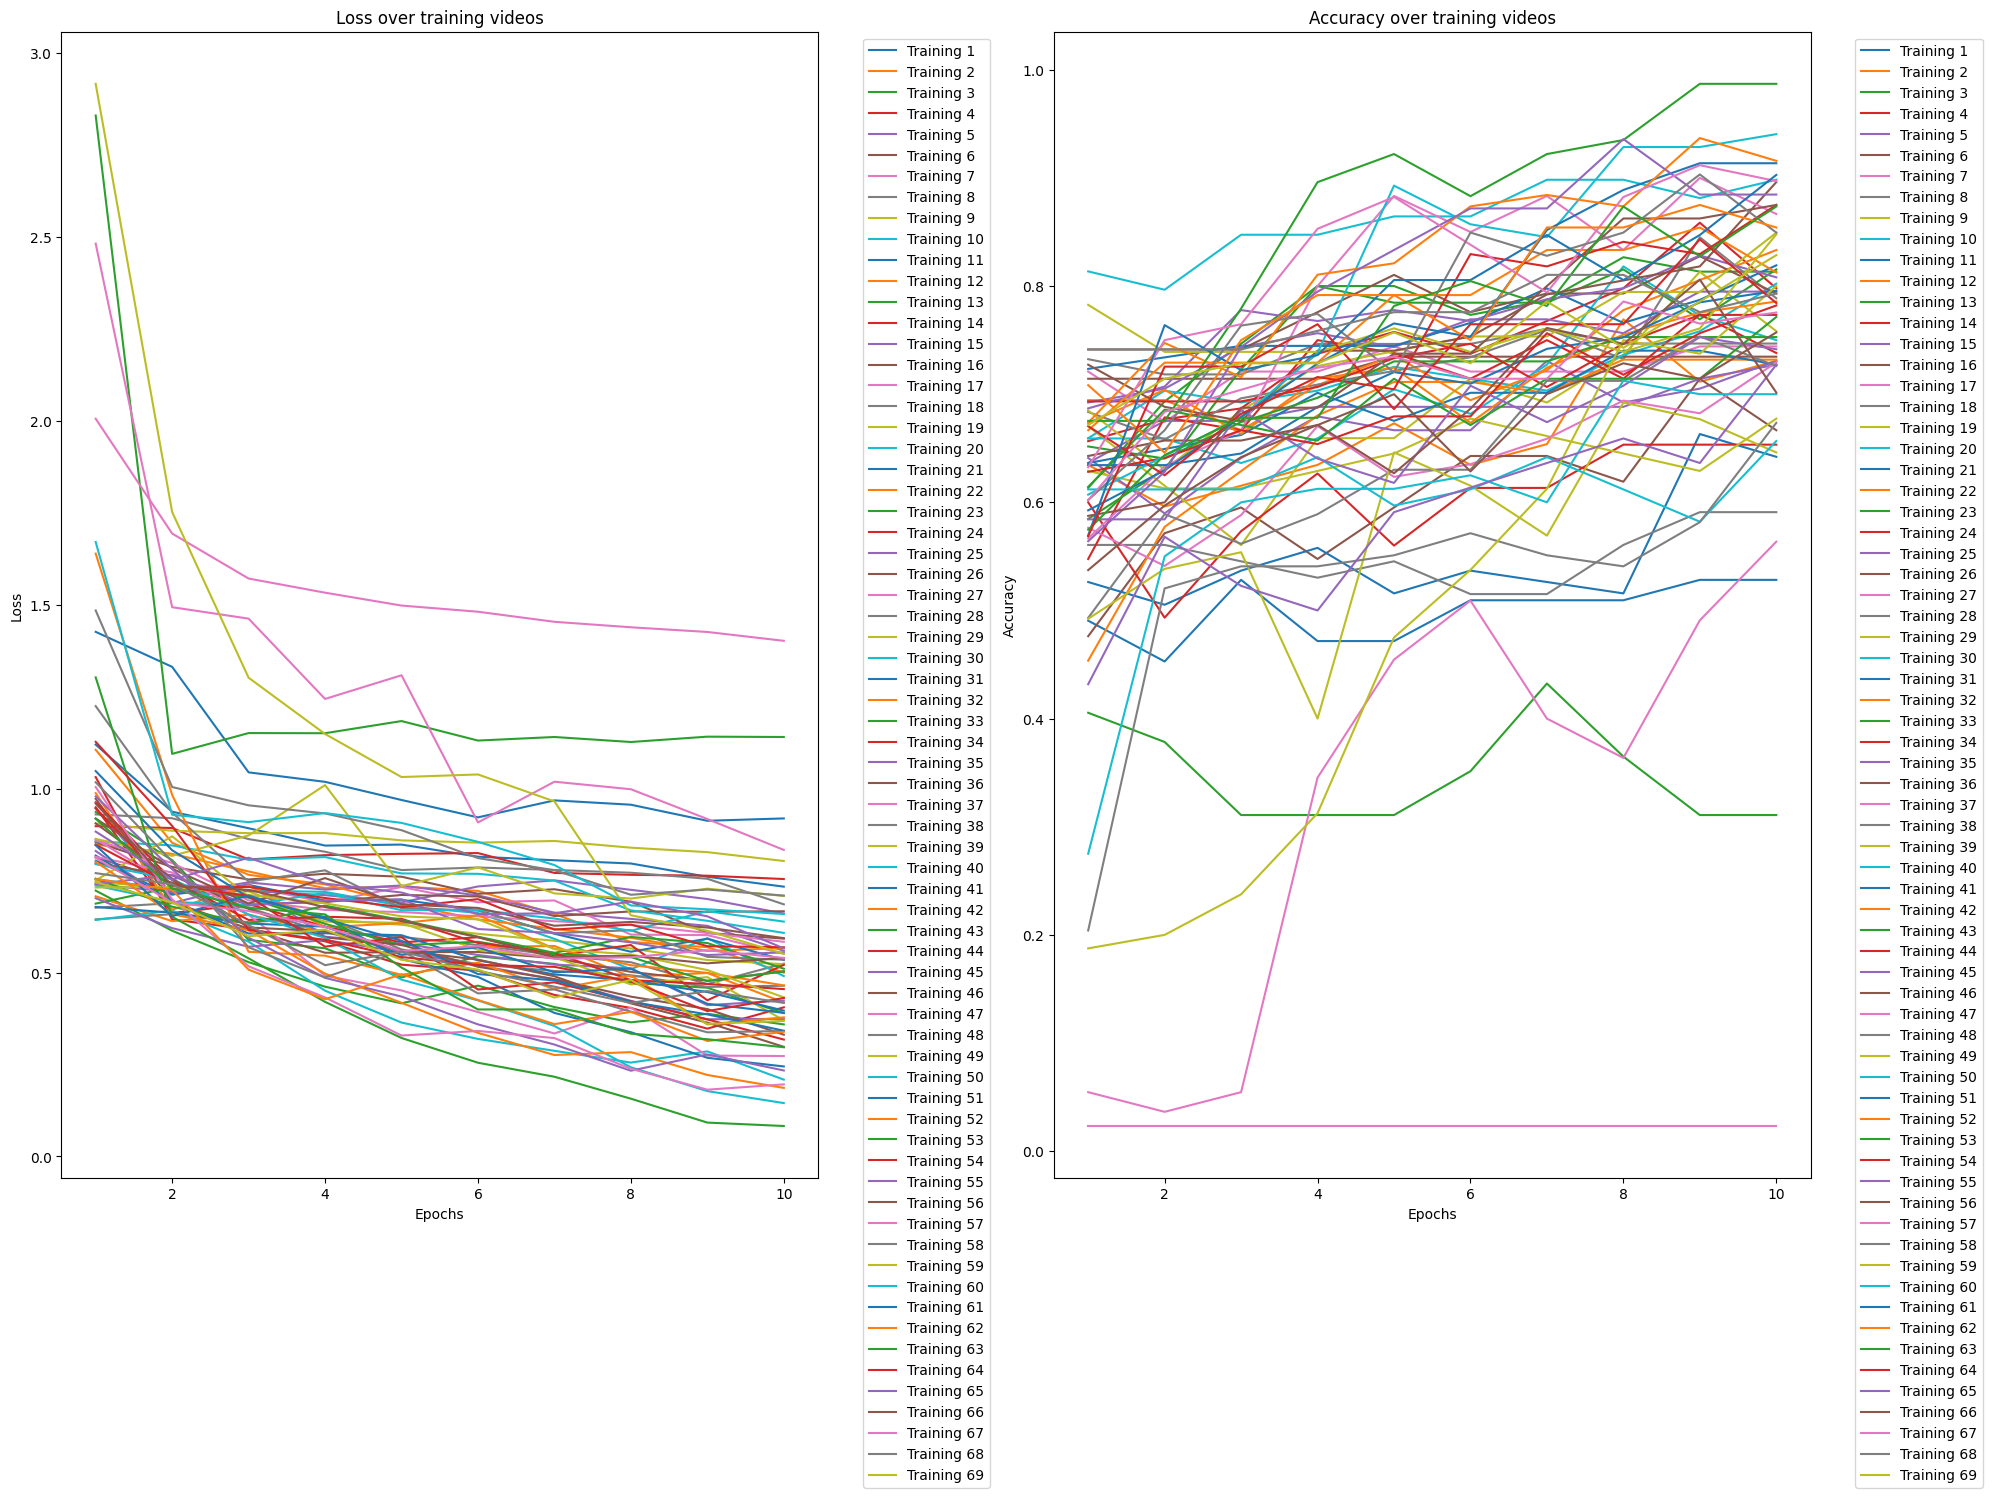

In [ ]:
plot_training_history(audio_hist)